In [ ]:
"""
Simulation of a Hospital
Input Distributions:
    1- Entering population: poisson with mean = 21 people per hour
        (Inter-arrival time: Exponential with mean = 21 minutes)
    2- Service1 time for urgent patients: triangular(22, 40, 62) minutes
    3- Service1 time for normal patients: 40 * beta(1, 3) + 3 minutes
    4- Service2 time for urgent patients: triangular(10, 12, 14) minutes
    5- Service2 time for normal patients: uniform(8, 12) minutes
Doctors have two turns of 10 minuets rest in each shift
No limits on queue length
People get served based on a FIFO discipline
Outputs:
    1- Average queue length for each prioririty
    2- Maximum queue length for each prioririty
    3- Average waiting time in queue for each priority
    4- doctors utilization
    5- Percentage of patients who do not have waiting times in queues
    6- Average staying time for each priority at system
    7- ...
System starts at an empty state with two free doctors
There are three queues:
    1- Queue1 is for first service of normal patients
    2- Queue2 is for second service of all patients
    3- Queue3 is for first service of urgant patients
Author: Negin Ashrafi
Date: 1/6/2022
"""

""" search 'get output' to find the one you want """

import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import pandas as pd
from colorama import Fore
from statistics import mean
from scipy import stats

global simulation_days

def starting_state():

    # State Variables
    state = dict()
    state['Queue Length Priority 1'] = 0
    state['Queue Length Priority 2'] = 0
    state['Queue Length Priority 3'] = 0
    state['Number of Free Doctors'] = 2
    state['Number of Resting Doctors'] = 0
    state['Rest Turn'] = 1      # The next rest will be: 1= First Rest, 2= Second Rest in current shift
    state['Unused Rest'] = 0    # 0: No Unused Rest, 1: Unused Rest

    # Save Data
    # To track each patient
    data = dict()
    data['Patient'] = dict()

    #To track the queue of each priority
    data['Queue'] = dict()
    data['Queue']['Queue 1'] = dict()
    data['Queue']['Queue 1']['length'] = dict()
    data['Queue']['Queue 1']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 1']['Arrival Times'] = dict()
    data['Queue']['Queue 2'] = dict()
    data['Queue']['Queue 2']['length'] = dict()
    data['Queue']['Queue 2']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 2']['Enter Times'] = dict()
    data['Queue']['Queue 3'] = dict()
    data['Queue']['Queue 3']['length'] = dict()
    data['Queue']['Queue 3']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 3']['Arrival Times'] = dict()

    #To track the time of changes
    #It will later be used to calculate the area under differnet curves
    data['Last Time Queue 1 Length Changed'] = 0
    data['Last Time Queue 2 Length Changed'] = 0
    data['Last Time Queue 3 Length Changed'] = 0
    data['Last Time Number of Free Doctors Changed'] = 0

    #Cumulative data
    data['Cumulative Stats'] = dict()
    data['Cumulative Stats']['Queue 1 Waiting Time'] = 0    #Sum of Waiting times in Queue 1 until now(t)
    data['Cumulative Stats']['Queue 2 Waiting Time'] = 0    #Sum of Waiting times in Queue 2 until now(t)
    data['Cumulative Stats']['Queue 3 Waiting Time'] = 0    #Sum of Waiting times in Queue 3 until now(t)
    data['Cumulative Stats']['Area Under Queue 1 Length Curve'] = 0    #Later used to calculate "Average Queue 1 Length"
    data['Cumulative Stats']['Area Under Queue 2 Length Curve'] = 0    #Later used to calculate "Average Queue 2 Length"
    data['Cumulative Stats']['Area Under Queue 3 Length Curve'] = 0    #Later used to calculate "Average Queue 3 Length"
    data['Cumulative Stats']['Area Under Number of Free Doctors Curve'] = 0    #Later used to calculate "Doctors' Efficiency"
    data['Cumulative Stats']['Priority 1 Service Starters'] = 0    #Number of normal patients that have started their first service
    data['Cumulative Stats']['Priority 2 Service Starters'] = 0    #Number of patients that have started their second service
    data['Cumulative Stats']['Priority 3 Service Starters'] = 0    #Number of urgent patients that have started their first service
    data['Cumulative Stats']['Urgent Service Finishers'] = 0    #Number of urgent patients that have finished their both services
    data['Cumulative Stats']['Normal Service Finishers'] = 0    #Number of normal patients that have finished their both services
    data['Cumulative Stats']['Total Time in System for Priority 1'] = 0    #Total time normal patients spends in system
    data['Cumulative Stats']['Total Time in System for Priority 2'] = 0    #Total time patients spend in system after their first service
    data['Cumulative Stats']['Total Time in System for Priority 3'] = 0    #Total time urgent patients spends in system
    data['Cumulative Stats']['Not Waited Priority 3'] = 0    #Number of urgent patients that start their first service as soon as they enter


    # Starting FEL
    future_event_list = list()
    future_event_list.append({'Event Type': 'Arrival', 'Event Time': 0 , 'Patient Name': 'P1'})
    future_event_list.append({'Event Type': 'End of Simulation', 'Event Time': simulation_days*1440, 'Patient Name': None })

    return state, future_event_list, data

# Making a list to save KPIs in each cycle
List_average_time_in_system_for_priority1 = list()
List_percent_of_not_waited_priority3_patients = list()
List_average_time_in_system_for_priority2 = list()
List_average_queue_length_priority1 = list()
List_average_queue_length_priority2 = list()
List_average_queue_length_priority3 = list()
List_max_queue_length_priority1 = list()
List_max_queue_length_priority2 = list()
List_max_queue_length_priority3 = list()
List_average_doctors_efficiency = list()
List_average_time_in_system_for_priority3 = list()
List_average_time_doctors_spend_for_each_patient = list()

# Making a list to save mean of KPIs in sach cycle of Sensitivity Analysis
List_KPI2 = list()
List_KPI4_average_priority3 = list()
List_KPI5 = list()

# Parametrs for Sensitivity Analysis
global exp_parameter
global urgent_percent
global last_parameter_triangular

exp_parameter = 21
urgent_percent = 0.4
last_parameter_triangular = 62

#Functions to make random variables
def Exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)

def Triangular(a, b, c):
    r = random.random()
    if r <= (b-a) / (c-a):
        return math.sqrt(r * (b-a) * (c-a)) + a
    else:
        return c - math.sqrt((1-r) * (c-b) * (c-a))

def Uniform(a, b):
    r = random.random()
    return a + (b - a) * r

def Beta(a, b):
    return np.random.beta(a, b)

#To add an event to "Future Event List"
def fel_maker(future_event_list, event_type, clock, data, Patient):
    #Generate the random time/duration
    event_time = 1

    if event_type == 'Arrival':
        event_time = clock + Exponential(1/exp_parameter)
    elif event_type == 'End of Service1':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(22, 40, last_parameter_triangular)
        else:
            event_time = clock + 40 * Beta(1, 3) + 3
    elif event_type == 'End of Service2':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(10, 12, 14)
        else:
            event_time = clock + Uniform(8, 12)
    elif event_type == 'Rest Time':
        event_time = clock + 60
    elif event_type == 'Start of Rest':
        event_time = clock
    elif event_type == 'End of Rest':
        event_time = clock + 10

    #Add the event to the list
    new_event = {'Event Type': event_type, 'Event Time': event_time, 'Patient Name': Patient}
    future_event_list.append(new_event)

#Event:Arrival
def Arrival(future_event_list, state, clock, data, Patient):

    #Define a new patient
    data['Patient'][Patient] = dict()
    data['Patient'][Patient]['Priority'] = dict()
    data['Patient'][Patient]['Priority']['First Service'] = 0
    data['Patient'][Patient]['Priority']['Second Service'] = 0
    data['Patient'][Patient]['Arrival Time'] = clock
    data['Patient'][Patient]['Start of Service'] = list()
    data['Patient'][Patient]['End of Service'] = list()

    #Assign a random priority
    r = random.random()
    if r <= urgent_percent:
        data['Patient'][Patient]['Priority']['First Service'] = 3
    else:
        data['Patient'][Patient]['Priority']['First Service'] = 1

    #Check the availability of doctors
    if state['Number of Free Doctors'] == 0:    #No doctors available
        #Check the patient's priority
        if data['Patient'][Patient]['Priority']['First Service'] == 3:   #Urgent patient

            #cumulative & data
            #Update the curve for queue 3 length
            data['Cumulative Stats']['Area Under Queue 3 Length Curve'] += \
                state['Queue Length Priority 3'] * (clock - data['Last Time Queue 3 Length Changed'])
            data['Last Time Queue 3 Length Changed'] = clock

            #Update queue 3 length and arrival times
            state['Queue Length Priority 3'] += 1
            data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
            data['Queue']['Queue 3']['Arrival Times'][Patient] = clock

            #Add patient to queue 3
            data['Queue']['Queue 3'][Patient] = dict()
            data['Queue']['Queue 3'][Patient]['Arrival Time'] = clock

        else: #Normal Patient

            #cumulative & data
            #Update the curve for queue length
            data['Cumulative Stats']['Area Under Queue 1 Length Curve'] += \
                state['Queue Length Priority 1'] * (clock - data['Last Time Queue 1 Length Changed'])
            data['Last Time Queue 1 Length Changed'] = clock

            #Update queue 1 length and arrival times
            state['Queue Length Priority 1'] += 1
            data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
            data['Queue']['Queue 1']['Arrival Times'][Patient] = clock

            #Add patient to queue 1
            data['Queue']['Queue 1'][Patient] = dict()
            data['Queue']['Queue 1'][Patient]['Arrival Time'] = clock

    else: #There is at least 1 free doctor

        #cumulative & data
        #Update the curve for free doctors
        data['Cumulative Stats']['Area Under Number of Free Doctors Curve'] += \
                state['Number of Free Doctors'] * (clock - data['Last Time Number of Free Doctors Changed'])
        data['Last Time Number of Free Doctors Changed'] = clock

        #Update the number of service starters according to patient's priority
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            data['Cumulative Stats']['Priority 3 Service Starters'] += 1
            data['Cumulative Stats']['Not Waited Priority 3'] += 1
        else:
            data['Cumulative Stats']['Priority 1 Service Starters'] += 1

        #Update data for patient
        data['Patient'][Patient]['Start of Service'].append(clock)

        state['Number of Free Doctors'] -= 1

        fel_maker(future_event_list, 'End of Service1', clock, data, Patient)

    #Generate new patient for next arrival
    next_patient = 'P' + str(int(Patient[1:]) + 1)
    fel_maker(future_event_list, 'Arrival', clock, data, next_patient)
    return Patient

def End_of_Service(future_event_list, state, clock, data, Patient):

    #cumulative & data
    data['Patient'][Patient]['End of Service'].append(clock)

    if data['Patient'][Patient]['Priority']['Second Service'] == 0:

        data['Cumulative Stats']['Area Under Queue 2 Length Curve'] += \
            state['Queue Length Priority 2'] * (clock - data['Last Time Queue 2 Length Changed'])
        data['Last Time Queue 2 Length Changed'] = clock

        data['Patient'][Patient]['Priority']['Second Service'] = 2
        state['Queue Length Priority 2'] += 1
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']
        data['Queue']['Queue 2']['Enter Times'][Patient] = clock

    else: #['Second Service'] = 2
        if data['Patient'][Patient]['Priority']['First Service'] == 1:
            data['Cumulative Stats']['Normal Service Finishers'] += 1
            data['Cumulative Stats']['Total Time in System for Priority 1'] += (clock - data['Patient'][Patient]['Arrival Time'])
        else: #Priority = 3
            data['Cumulative Stats']['Urgent Service Finishers'] += 1
            data['Cumulative Stats']['Total Time in System for Priority 3'] += (clock - data['Patient'][Patient]['Arrival Time'])

        data['Cumulative Stats']['Total Time in System for Priority 2'] += (clock - data['Patient'][Patient]['End of Service'][0])


    if state['Unused Rest']  == 1:
        state['Number of Resting Doctors'] += 1
        state['Unused Rest'] = 0
        fel_maker(future_event_list, 'Start of Rest', clock, data, Patient)
    else:
        Check_Queue(future_event_list, state, clock, data, Patient)


def Rest_Time(future_event_list, state, clock, data, Patient):
    if state['Number of Free Doctors'] > 0:
        fel_maker(future_event_list, 'Start of Rest', clock, data, Patient)
    else:
         state['Unused Rest'] = 1


def Start_of_Rest(future_event_list, state, clock, data, Patient):
    if state['Number of Free Doctors'] > 0:

        data['Cumulative Stats']['Area Under Number of Free Doctors Curve'] += \
            state['Number of Free Doctors'] * (clock - data['Last Time Number of Free Doctors Changed'])
        data['Last Time Number of Free Doctors Changed'] = clock

        state['Number of Free Doctors'] -= 1
    state['Number of Resting Doctors'] = 1
    fel_maker(future_event_list, 'End of Rest', clock, data, Patient)


def End_of_Rest(future_event_list, state, clock, data, Patient):

    if state['Rest Turn'] == 1:
        fel_maker(future_event_list, 'Rest Time', clock, data, Patient)
        state['Rest Turn'] = 2
    else:
        state['Rest Turn'] = 1

    state['Number of Resting Doctors'] = 0

    Check_Queue(future_event_list, state, clock, data, Patient)


def Check_Queue(future_event_list, state, clock, data, Patient):

    # first we should check the priority 3. if it is empty we can countinue checking other priorities in order
    if state['Queue Length Priority 3'] > 0:

        data['Cumulative Stats']['Area Under Queue 3 Length Curve'] += \
                state['Queue Length Priority 3'] * (clock - data['Last Time Queue 3 Length Changed'])
        data['Last Time Queue 3 Length Changed'] = clock

        first_patient_in_queue3 = min(data['Queue']['Queue 3']['Arrival Times'],
                                      key=data['Queue']['Queue 3']['Arrival Times'].get)
        poping_patient = str(first_patient_in_queue3)
        data['Queue']['Queue 3']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 3'] -= 1

        data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
        last_cumulative = data['Cumulative Stats']['Queue 3 Waiting Time']
        data['Cumulative Stats']['Queue 3 Waiting Time'] += clock - data['Patient'][Patient]['Arrival Time']
        data['Cumulative Stats']['Priority 3 Service Starters'] += 1
        data['Patient'][Patient]['Start of Service'].append(clock)

        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    elif state['Queue Length Priority 2'] > 0:

        data['Cumulative Stats']['Area Under Queue 2 Length Curve'] += \
                state['Queue Length Priority 2'] * (clock - data['Last Time Queue 2 Length Changed'])
        data['Last Time Queue 2 Length Changed'] = clock

        first_patient_in_queue2 = min(data['Queue']['Queue 2']['Enter Times'],
                                      key=data['Queue']['Queue 2']['Enter Times'].get)
        poping_patient = str(first_patient_in_queue2)
        data['Queue']['Queue 2']['Enter Times'].pop(poping_patient, None)
        state['Queue Length Priority 2'] -= 1
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']


        data['Cumulative Stats']['Priority 2 Service Starters'] += 1

        data['Cumulative Stats']['Queue 2 Waiting Time'] += clock - data['Patient'][Patient]['End of Service'][0]
        data['Patient'][Patient]['Start of Service'].append(clock)

        fel_maker(future_event_list, 'End of Service2', clock, data, poping_patient)

    elif state['Queue Length Priority 1'] > 0:

        data['Cumulative Stats']['Area Under Queue 1 Length Curve'] += \
                state['Queue Length Priority 1'] * (clock - data['Last Time Queue 1 Length Changed'])
        data['Last Time Queue 1 Length Changed'] = clock

        first_patient_in_queue1 = min(data['Queue']['Queue 1']['Arrival Times'],
                                      key=data['Queue']['Queue 1']['Arrival Times'].get)
        poping_patient = str(first_patient_in_queue1)
        data['Queue']['Queue 1']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 1'] -= 1

        data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
        data['Cumulative Stats']['Queue 1 Waiting Time'] += clock - data['Patient'][Patient]['Arrival Time']

        data['Cumulative Stats']['Priority 1 Service Starters'] += 1
        data['Patient'][Patient]['Start of Service'].append(clock)

        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    else:

        data['Cumulative Stats']['Area Under Number of Free Doctors Curve'] += \
            state['Number of Free Doctors'] * (clock - data['Last Time Number of Free Doctors Changed'])
        data['Last Time Number of Free Doctors Changed'] = clock

        state['Number of Free Doctors'] += 1

# This print section is just for checking.
def print_header():
    print('\n')
    print('No.\t' + 'Event Type'.ljust(30) + '\t' + 'Patient'.ljust(5) + '\t'+ 'Time'.ljust(10) + '\t' +
          'Queue Length Priority 1'.ljust(5) + '\t' 'Queue Length Priority 2'.ljust(5) + '\t' +
          'Queue Length Priority 3'.ljust(5) + '\t' + 'Number of Free Doctors'.ljust(5) + '\t' +
          'Number of Resting Doctors'.ljust(5) + '\t' + 'Unused Rest')
    print('---------------------------------------------------------------------------------------------------------------------------')

def nice_print(current_state, current_event, i, data, Patient):

    flag = 0
    kind = 0
    if current_event['Event Type'] == 'Arrival':
        flag = data['Patient'][Patient]['Priority']['First Service']
        kind = 'Priority'
    elif current_event['Event Type'] == 'Rest Time' or current_event['Event Type'] == 'Start of Rest' \
        or current_event['Event Type'] == 'End of Rest':
        flag = current_state['Rest Turn']
        kind = 'Turn'
        Patient = '-'
    elif current_event['Event Type'] == 'End of Simulation':
        flag = ''
        kind = ''
        Patient = '-'
    else:
         if current_event['Event Type'] == 'End of Service1' or current_event['Event Type'] == 'End of Service2':
            flag = ''
            kind = ''

    if i % 2 == 0:
        print(Fore.BLUE + str(i) + '\t' + (str(current_event['Event Type']) +  ':' + str(kind) + str(flag)).ljust(30)
        + '\t' +str(Patient).ljust(5) + '\t' + str(round(current_event['Event Time'], 3)).ljust(10)
        + '\t' + str(current_state['Queue Length Priority 1']).ljust(5) + '\t' + str(current_state['Queue Length Priority 2']).ljust(5)
        + '\t' + str(current_state['Queue Length Priority 3']).ljust(5) + '\t' + str(current_state['Number of Free Doctors']).ljust(5)
        + '\t' +  str(current_state['Number of Resting Doctors']).ljust(5) + '\t' + str(current_state['Unused Rest']))

    else:
        print(Fore.RED  + str(i) + '\t' + (str(current_event['Event Type']) +  ':' + str(kind) + str(flag)).ljust(30)
        + '\t' + str(Patient).ljust(5)+ '\t' + str(round(current_event['Event Time'], 3)).ljust(10)
        + '\t' + str(current_state['Queue Length Priority 1']).ljust(5) + '\t' + str(current_state['Queue Length Priority 2']).ljust(5)
        + '\t' + str(current_state['Queue Length Priority 3']).ljust(5) + '\t' + str(current_state['Number of Free Doctors']).ljust(5)
        + '\t' + str(current_state['Number of Resting Doctors']).ljust(5) + '\t' + str(current_state['Unused Rest']))

def create_row(step, current_event, state, data, future_event_list):
    # This function will create a list, which will eventually become a row of the excel file

    sorted_fel = sorted(future_event_list, key=lambda x: x['Event Time'])

    row = [step, current_event['Event Time'], current_event['Event Type'], current_event['Patient Name']]

    row.extend(list(state.values()))

    row.extend(list(data['Cumulative Stats'].values()))

    for event in sorted_fel:
        row.append(event['Event Time'])
        row.append(event['Event Type'])

        if event['Event Type'] == "Arrival" or event['Event Type'] == "End of Service1" or event['Event Type'] == "End of Service2":
            row.append(event['Patient Name'])
        else:
            row.append('')
    return row

def justify(table):

    row_max_len = 0
    for row in table:
        if len(row) > row_max_len:
            row_max_len = len(row)

    # For each row, add enough blanks
    for row in table:
        row.extend([""] * (row_max_len - len(row)))


def create_main_header(state, data):

    header = ['Step', 'Clock', 'Event Type', 'Event Patient']
    header.extend(list(state.keys()))
    header.extend(list(data['Cumulative Stats'].keys()))
    return header


def create_excel(table, header):

    row_len = len(table[0])
    header_len = len(header)
    i = 1
    for col in range((row_len - header_len) // 3):
        header.append('Future Event Time ' + str(i))
        header.append('Future Event Type ' + str(i))
        header.append('Future Event Patient ' + str(i))
        i += 1

    df = pd.DataFrame(table, columns=header, index=None)

    writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')

    df.to_excel(writer, sheet_name='5 days of Queue Output', header=False, startrow=1, index=False)

    workbook = writer.book

    worksheet = writer.sheets['5 days of Queue Output']

    header_formatter = workbook.add_format()

    header_formatter.set_align('center')
    header_formatter.set_align('vcenter')
    header_formatter.set_font('Times New Roman')
    header_formatter.set_bold('True')


    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_formatter)


    for i, width in enumerate(get_col_widths(df)):
        worksheet.set_column(i - 1, i - 1, width)


    main_formatter = workbook.add_format()
    main_formatter.set_align('center')
    main_formatter.set_align('vcenter')
    main_formatter.set_font('Times New Roman')


    for row in range(1, len(df) + 1):
        worksheet.set_row(row, None, main_formatter)

    writer.save()


def get_col_widths(dataframe):

    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


def calc_KPIs(data, state):
    #1
    average_time_in_system_for_priority1 = data['Cumulative Stats']['Total Time in System for Priority 1'] / \
    data['Cumulative Stats']['Normal Service Finishers']

    List_average_time_in_system_for_priority1.append(round(average_time_in_system_for_priority1, 3))

    #2
    percent_of_not_waited_priority3_patients = 100*data['Cumulative Stats']['Not Waited Priority 3'] / \
    data['Cumulative Stats']['Priority 3 Service Starters']

    List_percent_of_not_waited_priority3_patients.append(round(percent_of_not_waited_priority3_patients, 3))

    #3
    average_time_in_system_for_priority2 = data['Cumulative Stats']['Total Time in System for Priority 2'] / \
    (data['Cumulative Stats']['Normal Service Finishers'] + data['Cumulative Stats']['Urgent Service Finishers'])

    List_average_time_in_system_for_priority2.append(round(average_time_in_system_for_priority2, 3))

    #4
    average_queue_length_priority1 = data['Cumulative Stats']['Area Under Queue 1 Length Curve'] / (simulation_days*1440)
    average_queue_length_priority2 = data['Cumulative Stats']['Area Under Queue 2 Length Curve'] / (simulation_days*1440)
    average_queue_length_priority3 = data['Cumulative Stats']['Area Under Queue 3 Length Curve'] / (simulation_days*1440)

    max_queue_length_priority1 = max(data['Queue']['Queue 1']['length'].values())
    max_queue_length_priority2 = max(data['Queue']['Queue 2']['length'].values())
    max_queue_length_priority3 = max(data['Queue']['Queue 3']['length'].values())

    List_average_queue_length_priority1.append(average_queue_length_priority1)
    List_average_queue_length_priority2.append(average_queue_length_priority2)
    List_average_queue_length_priority3.append(average_queue_length_priority3)

    List_max_queue_length_priority1.append(max_queue_length_priority1)
    List_max_queue_length_priority2.append(max_queue_length_priority2)
    List_max_queue_length_priority3.append(max_queue_length_priority3)

    #5
    average_doctors_efficiency = 1 -((data['Cumulative Stats']['Area Under Number of Free Doctors Curve'] / (simulation_days*1440)) / 2)
    List_average_doctors_efficiency.append(average_doctors_efficiency)

    #6
    average_time_in_system_for_priority3 = data['Cumulative Stats']['Total Time in System for Priority 3'] / \
    data['Cumulative Stats']['Urgent Service Finishers']

    List_average_time_in_system_for_priority3.append(round(average_time_in_system_for_priority3, 3))

    #7
    average_time_doctors_spend_for_each_patient = (2 * simulation_days*1440 - \
                                                   data['Cumulative Stats']['Area Under Number of Free Doctors Curve']) / \
    (data['Cumulative Stats']['Normal Service Finishers'] + data['Cumulative Stats']['Urgent Service Finishers'])

    List_average_time_doctors_spend_for_each_patient.append(round(average_time_doctors_spend_for_each_patient, 3))

def excel_creator(state, data, table):
    excel_main_header = create_main_header(state, data)
    justify(table)
    create_excel(table, excel_main_header)


def Confidence_Intervals(out_put):
    H = -stats.t.ppf(0.025, 4) * np.std(out_put) / math.sqrt(5)
    lower_band = np.mean(out_put) - H
    upper_band = np.mean(out_put) + H
    print("\t The lower band is: ", round(lower_band, 3))
    print("\t The upper band is: ", round(upper_band, 3))


def Simulation(simulation_time):

    state, future_event_list, data = starting_state()
    clock = 0
#     print_header()
    table = []
    i = 1
    counter = 0
    day = 1
    while clock < simulation_time:

        sorted_fel = sorted(future_event_list, key=lambda x: x['Event Time'])
        current_event = sorted_fel[0]
        clock = current_event['Event Time']
        Patient = current_event['Patient Name']

        if clock < simulation_time:  # if current_event['Event Type'] != 'End of Simulation'  (No difference)
            if current_event['Event Type'] == 'Arrival':
                Patient = Arrival(future_event_list, state, clock, data, Patient)
            elif current_event['Event Type'] == 'End of Service1' or current_event['Event Type'] == 'End of Service2':
                End_of_Service(future_event_list, state, clock, data, Patient)
            elif current_event['Event Type'] == 'Rest Time':
                Rest_Time(future_event_list, state, clock, data, Patient)
            elif current_event['Event Type'] == 'Start of Rest':
                Start_of_Rest(future_event_list, state, clock, data, Patient)
            elif current_event['Event Type'] == 'End of Rest':
                End_of_Rest(future_event_list, state, clock, data, Patient)
            future_event_list.remove(current_event)
        else:
            future_event_list.clear()
#         nice_print(state, current_event, i, data, Patient)

        if counter == 0:
            for day in range(1,simulation_days):
                future_event_list.append({'Event Type': 'Rest Time', 'Event Time': 1440*(day-1) + 300, 'Patient Name': Patient})
                future_event_list.append({'Event Type': 'Rest Time', 'Event Time': 1440*(day-1) + 780, 'Patient Name': Patient})
                future_event_list.append({'Event Type': 'Rest Time', 'Event Time': 1440*(day-1) + 1260, 'Patient Name': Patient})
            counter = 1

        table.append(create_row(i, current_event, state, data, future_event_list))
        i += 1
    calc_KPIs(data, state)


    """to get output of excel, uncomment below lines"""
#     excel_creator(state, data, table)

# simulation_days = 5
# Simulation(simulation_days * 1440)


""" to get ouput of KPIs, uncomment below lines & comment other outputs"""
simulation_days = 20
for cycle in range(1,100):
     Simulation(simulation_days * 1440)

print(' KPI 1 : average time in system for priority1= ' , round(np.mean(List_average_time_in_system_for_priority1), 3))

print('\n KPI 2 : percent of not waited priority3 patients= ' , round(np.mean(List_percent_of_not_waited_priority3_patients), 3))

print('\n KPI 3 : average time in system for priority2= ' , round(np.mean(List_average_time_in_system_for_priority2), 3))

print('\n KPI 4 : average queue length priority1=', round(np.mean(List_average_queue_length_priority1), 3))
print('\n\t average queue length priority2=', round(np.mean(List_average_queue_length_priority2), 3))
print('\n\t average queue length priority3=', round(np.mean(List_average_queue_length_priority3), 3))
print('\n\t max queue length priority1=', round(np.mean(List_max_queue_length_priority1), 3))
print('\n\t max queue length priority2=', round(np.mean(List_max_queue_length_priority2), 3))
print('\n\t max queue length priority3=', round(np.mean(List_max_queue_length_priority3), 3))

print('\n KPI 5 : average doctors efficiency=', round(np.mean(List_average_doctors_efficiency), 3))

print('\n KPI 6 : average time in system for priority3= ' , round(np.mean(List_average_time_in_system_for_priority3), 3))

print('\n KPI 7 : average time doctors spend for each patient=' , round(np.mean(List_average_time_doctors_spend_for_each_patient), 3))

"""" to get output of Confidence Intervals, uncomment below lines """
# simulation_days = 20
# for cycle in range(1,10):
#      Simulation(simulation_days * 1440)

# print("KPIs and Confidence Intervals for 10 cycles:\n")

# print('\n KPI 1 : average time in system for priority1= ' , round(np.mean(List_average_time_in_system_for_priority1), 3))
# Confidence_Intervals(List_average_time_in_system_for_priority1)

# print('\n KPI 2 : percent of not waited priority3 patients= ' , round(np.mean(List_percent_of_not_waited_priority3_patients), 3))
# Confidence_Intervals(List_percent_of_not_waited_priority3_patients)

# print('\n KPI 4 : average queue length priority3=', round(np.mean(List_average_queue_length_priority3), 3))
# Confidence_Intervals(List_average_queue_length_priority3)

# print('\n KPI 5 : average doctors efficiency=', round(np.mean(List_average_doctors_efficiency), 3))
# Confidence_Intervals(List_average_doctors_efficiency)

# print('\n KPI 7 : average time doctors spend for each patient=' , round(np.mean(List_average_time_doctors_spend_for_each_patient), 3))
# Confidence_Intervals(List_average_time_doctors_spend_for_each_patient)


""" to get output of sensitivity analysis for exponential parameter, uncomment below lines """
# List_exp_parameter = [15, 21, 27, 33, 39, 45]
# print("Sensitivity analysis for exponential parameter:\n")

# for k in range (0,6):
#     exp_parameter = List_exp_parameter[k]
#     simulation_days = 20
#     for cycle in range(1,200):
#          Simulation(simulation_days * 1440)


#     List_KPI2.append(np.mean(List_percent_of_not_waited_priority3_patients))
#     List_percent_of_not_waited_priority3_patients.clear()

#     List_KPI4_average_priority3.append(np.mean(List_average_queue_length_priority3))
#     List_average_queue_length_priority3.clear()

#     List_KPI5.append(np.mean(List_average_doctors_efficiency))
#     List_average_doctors_efficiency.clear()


# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_exp_parameter, List_KPI2)
# ax.set_title('percent of not waited priority3 patients')
# ax.set_xlabel('exponential parameter')
# ax.set_ylabel('percent of not waited priority3 patients')

# fig.savefig('Sensitivity analysis for exponential parameter kpi2.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_exp_parameter, List_KPI4_average_priority3)
# ax.set_title('average queue length priority3')
# ax.set_xlabel('exponential parameter')
# ax.set_ylabel('average queue length priority3')

# fig.savefig('Sensitivity analysis for exponential parameter kpi4.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_exp_parameter, List_KPI5)
# ax.set_title('average doctors efficiency')
# ax.set_xlabel('exponential parameter')
# ax.set_ylabel('average doctors efficiency')

# fig.savefig('Sensitivity analysis for exponential parameter kpi5.svg', format='svg')
# fig.show()


# List_KPI2.clear()
# List_KPI4_average_priority3.clear()
# List_KPI5.clear()


"""" to get output of sensitivity analysis for percent of urgent patients, uncomment below lines """
# List_urgent_percent = [0.2, 0.3, 0.4, 0.5, 0.6]
# print("Sensitivity analysis for percent of urgent patients:\n")

# for k in range (0,5):
#     urgent_percent = List_urgent_percent[k]
#     simulation_days = 20
#     for cycle in range(1,200):
#         Simulation(simulation_days * 1440)

#     List_KPI2.append(np.mean(List_percent_of_not_waited_priority3_patients))
#     List_percent_of_not_waited_priority3_patients.clear()

#     List_KPI4_average_priority3.append(np.mean(List_average_queue_length_priority3))
#     List_average_queue_length_priority3.clear()

#     List_KPI5.append(np.mean(List_average_doctors_efficiency))
#     List_average_doctors_efficiency.clear()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_urgent_percent, List_KPI2)
# ax.set_title('percent of not waited priority3 patients')
# ax.set_xlabel('urgent percent')
# ax.set_ylabel('percent of not waited priority3 patients')

# fig.savefig('Sensitivity analysis for urgent percent kpi2.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_urgent_percent, List_KPI4_average_priority3)
# ax.set_title('average queue length priority3')
# ax.set_xlabel('urgent percent')
# ax.set_ylabel('average queue length priority3')

# fig.savefig('Sensitivity analysis for urgent percent kpi4.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_urgent_percent, List_KPI5)
# ax.set_title('average doctors efficiency')
# ax.set_xlabel('urgent percent')
# ax.set_ylabel('average doctors efficiency')

# fig.savefig('Sensitivity analysis for urgent percent kpi5.svg', format='svg')
# fig.show()


# List_KPI2.clear()
# List_KPI4_average_priority3.clear()
# List_KPI5.clear()


"""" to get output of sensitivity analysis for last parameter of triangular distribution for first serivce
    of urgent patients, uncomment below lines """
# List_last_parameter_triangular = [45, 50, 55 , 60, 62, 65, 70, 75]
# print("Sensitivity analysis for last triangular parameter in first service of urgent patients:\n")

# for k in range (0,8):
#     last_parameter_triangular = List_last_parameter_triangular[k]
#     simulation_days = 20
#     for cycle in range(1,200):
#          Simulation(simulation_days * 1440)

#     List_KPI2.append(np.mean(List_percent_of_not_waited_priority3_patients))
#     List_percent_of_not_waited_priority3_patients.clear()

#     List_KPI4_average_priority3.append(np.mean(List_average_queue_length_priority3))
#     List_average_queue_length_priority3.clear()

#     List_KPI5.append(np.mean(List_average_doctors_efficiency))
#     List_average_doctors_efficiency.clear()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_last_parameter_triangular, List_KPI2)
# ax.set_title('percent of not waited priority3 patients')
# ax.set_xlabel('last triangular parameter (c) in first service of urgent patients')
# ax.set_ylabel('percent of not waited priority3 patients')

# fig.savefig('Sensitivity analysis for last triangular parameter in first service of urgent patients kpi2.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_last_parameter_triangular, List_KPI4_average_priority3)
# ax.set_title('average queue length priority3')
# ax.set_xlabel('last triangular parameter (c) in first service of urgent patients')
# ax.set_ylabel('average queue length priority3')

# fig.savefig('Sensitivity analysis for last triangular parameter in first service of urgent patients kpi4.svg', format='svg')
# fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(List_last_parameter_triangular, List_KPI5)
# ax.set_title('average doctors efficiency')
# ax.set_xlabel('last triangular parameter (c) in first service of urgent patients')
# ax.set_ylabel('average doctors efficiency')

# fig.savefig('Sensitivity analysis for last triangular parameter in first service of urgent patients kpi5.svg', format='svg')
# fig.show()


# List_KPI2.clear()
# List_KPI4_average_priority3.clear()
# List_KPI5.clear()

""" End """""

 KPI 1 : average time in system for priority1=  151.058

 KPI 2 : percent of not waited priority3 patients=  21.162

 KPI 3 : average time in system for priority2=  24.89

 KPI 4 : average queue length priority1= 3.548

	 average queue length priority2= 0.671

	 average queue length priority3= 0.166

	 max queue length priority1= 23.222

	 max queue length priority2= 11.424

	 max queue length priority3= 4.121

 KPI 5 : average doctors efficiency= 0.856

 KPI 6 : average time in system for priority3=  90.559

 KPI 7 : average time doctors spend for each patient= 36.088


' End '

C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_1088/1445391215.py:685: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, column].set_xticklabels(ax[0, column].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_1088/1445391215.py:695: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, column].set_xticklabels(ax[1, column].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_1088/1445391215.py:705: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, column].set_xticklabels(ax[2, column].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_1088/1445391215.py:715: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3, column].set_xticklabels(ax[3, column].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_1088/1445391215.py:725: UserWarning: FixedFormatter should only 

	 Point Estimate for finishing_patients_replication_average is: -0.044
	 The lower band for finishing_patients_replication_average is: -0.451
	 The upper band for finishing_patients_replication_average is: 0.363 

	 Point Estimate for time_in_system_priority1_replication_average is: 8.368
	 The lower band for time_in_system_priority1_replication_average is: -4.687
	 The upper band for time_in_system_priority1_replication_average is: 21.422 

	 Point Estimate for time_in_system_priority3_replication_average is: -15.447
	 The lower band for time_in_system_priority3_replication_average is: -18.531
	 The upper band for time_in_system_priority3_replication_average is: -12.364 

	 Point Estimate for time_in_system_total_replication_average is: -0.946
	 The lower band for time_in_system_total_replication_average is: -9.989
	 The upper band for time_in_system_total_replication_average is: 8.097 

	 Point Estimate for waiting_time_replication_average is: -22.015
	 The lower band for waiting_tim

' End '

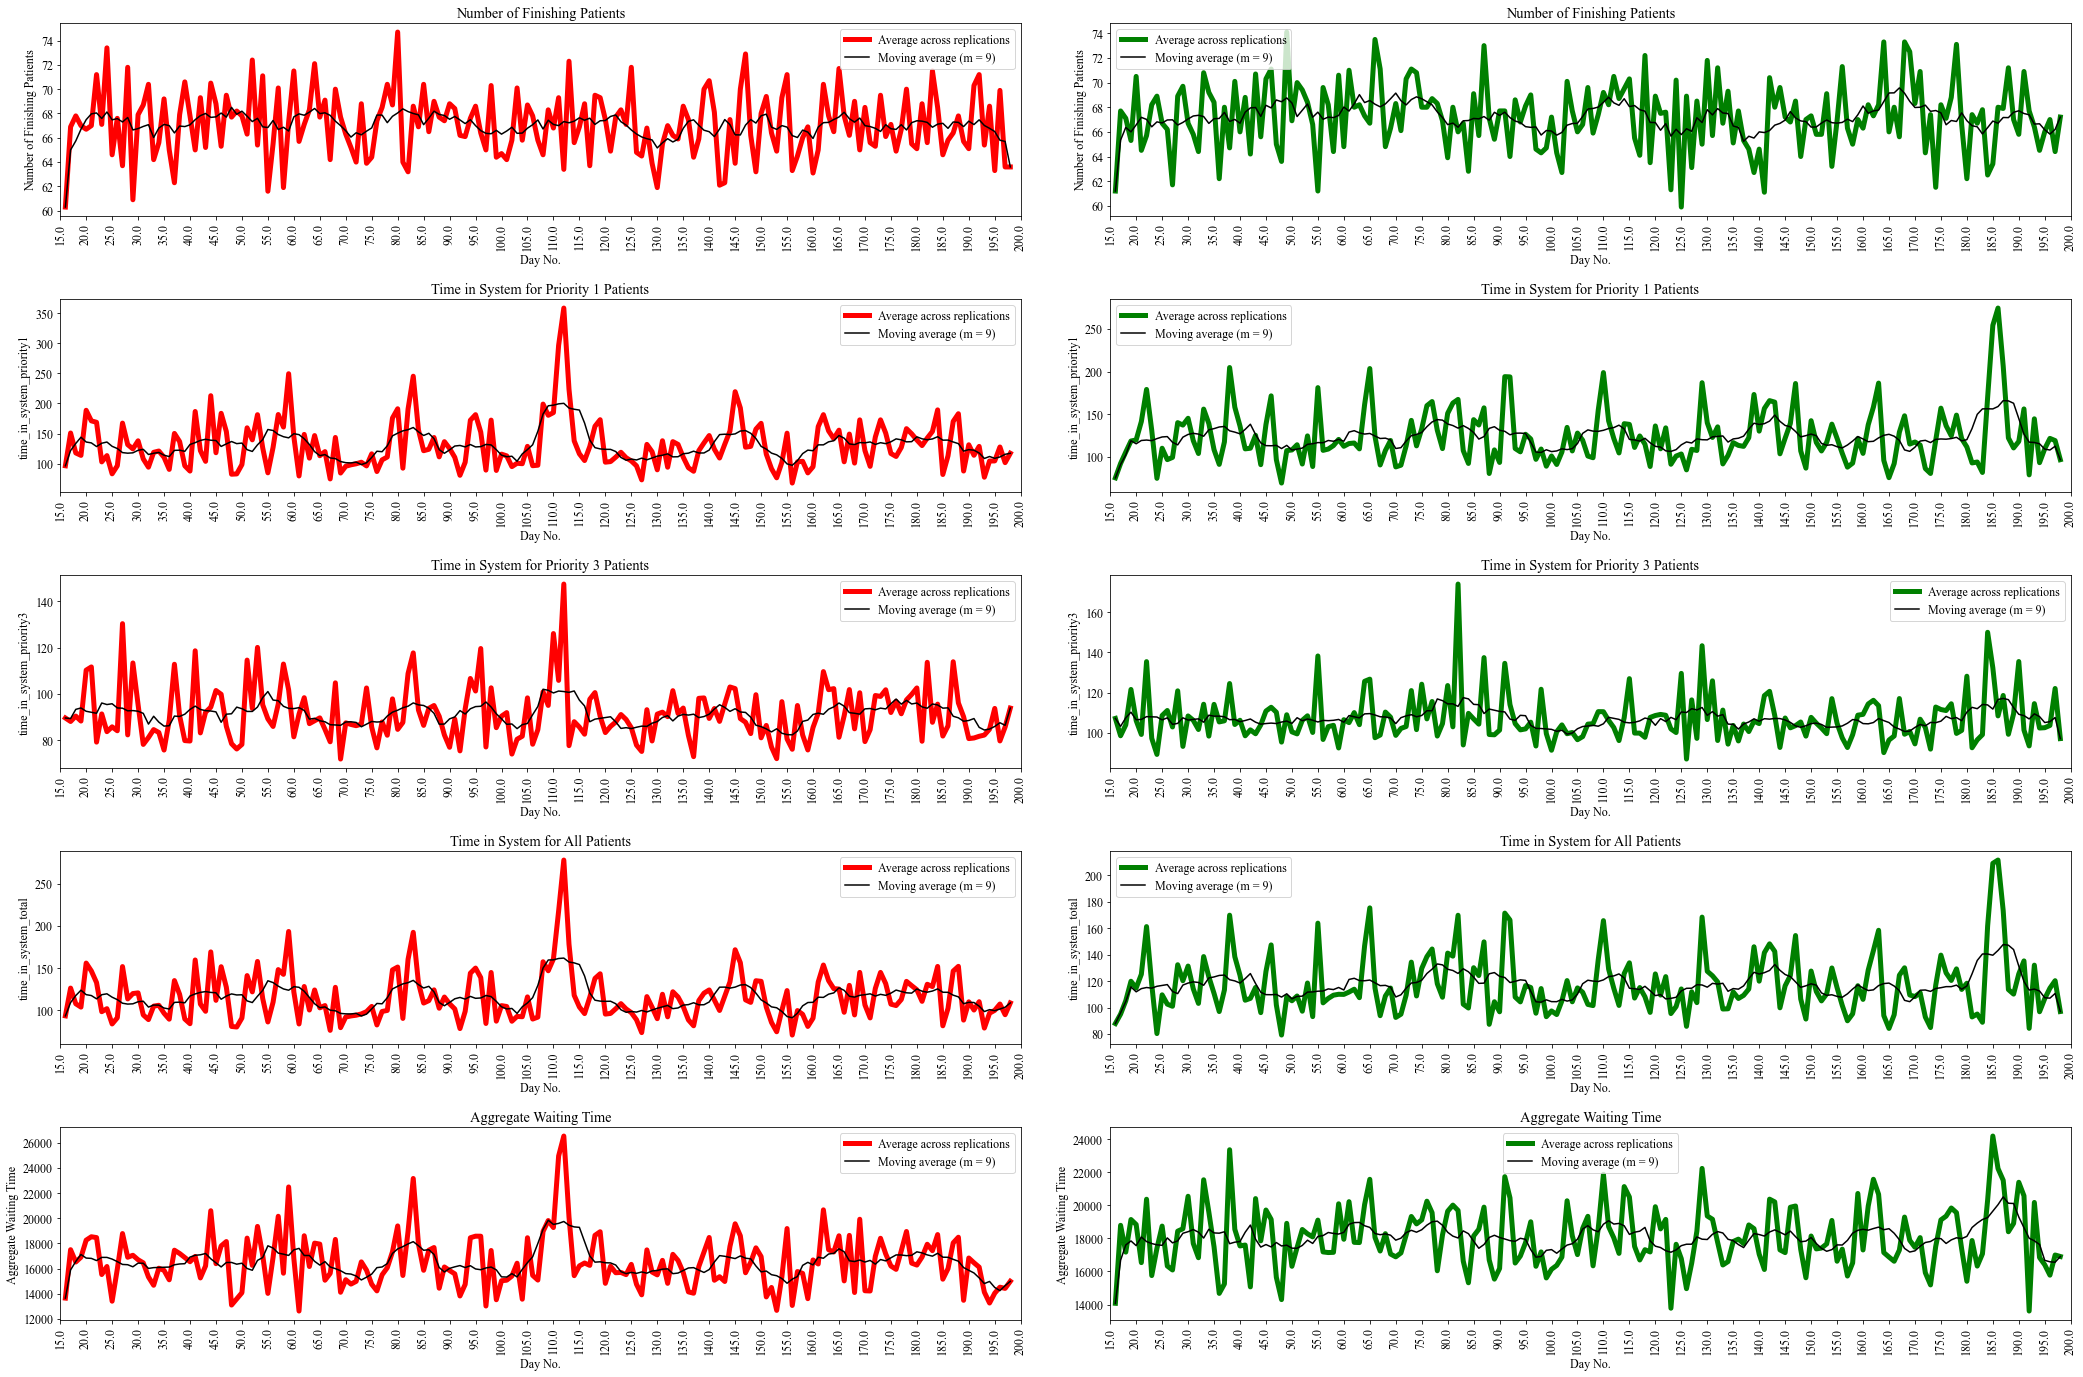

In [ ]:
"""
Simulation of a Clinic and Comparison of two systems

Input Distributions for main system:
    1- Entering population: poisson with mean = 21 people per hour
        (Inter-arrival time: Exponential with mean = 21 minutes)
    2- Service1 time for urgent patients: triangular(22, 40, 62) minutes
    3- Service1 time for normal patients: 40 * beta(1, 3) + 3 minutes
    4- Service2 time for urgent patients: triangular(10, 12, 14) minutes
    5- Service2 time for normal patients: uniform(8, 12) minutes
Input Distributions for new system:
    1- Entering population: poisson with mean = 21 people per hour
        (Inter-arrival time: Exponential with mean = 21 minutes)
    2- Service1 time for urgent patients: triangular(15, 60, 105) minutes
    3- Service1 time for normal patients: uniform(10, 30) minutes
    4- Service2 time for urgent patients: triangular(10, 18, 26) minutes
    5- Service2 time for normal patients: uniform(9, 20) minutes

No limits on queue length
People get served based on a FIFO discipline
Outputs:
    1- finishing patients replication average
    2- time in system priority1 replication average
    3- time in system priority3 replication average
    4- time in system total replication average
    5- waiting time replication average

Main system starts at an empty state with two free doctors
New system starts at an empty state with three free doctors

Author: Negin Ashrafi
Date: 2/5/2022
"""

import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import pandas as pd
from colorama import Fore
from statistics import mean
from scipy import stats

def starting_state():

    # State Variables
    state = dict()
    state['Queue Length Priority 1'] = 0
    state['Queue Length Priority 2'] = 0
    state['Queue Length Priority 3'] = 0
    state['Number of Free Doctors'] = number_of_doctors

    # Save Data
        # To track each patient
    data = dict()
    data['Patient'] = dict()

        #To track the queue of each priority
    data['Queue'] = dict()
    data['Queue']['Queue 1'] = dict()
    data['Queue']['Queue 1']['length'] = dict()
    data['Queue']['Queue 1']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 1']['Arrival Times'] = dict()
    data['Queue']['Queue 2'] = dict()
    data['Queue']['Queue 2']['length'] = dict()
    data['Queue']['Queue 2']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 2']['Enter Times'] = dict()
    data['Queue']['Queue 3'] = dict()
    data['Queue']['Queue 3']['length'] = dict()
    data['Queue']['Queue 3']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 3']['Arrival Times'] = dict()

    # Starting FEL
    future_event_list = list()
    future_event_list.append({'Event Type': 'Arrival', 'Event Time': 0 , 'Patient Name': 'P1'})
    future_event_list.append({'Event Type': 'End of Simulation', 'Event Time': simulation_days*1440, 'Patient Name': None })

    return state, future_event_list, data

global simulation_days
global replication_number

simulation_days = 200
replication_number = 10
window_size = 9
tick_spacing = 5


system = ['main', 'new']

global number_of_doctors

# p: Priority, s:Service, Parameter a/b/c
global p1_s1_a
global p1_s1_b

global p1_s2_a
global p1_s2_b

global p3_s1_a
global p3_s1_b
global p3_s1_c

global p3_s2_a
global p3_s2_b
global p3_s2_c

global column


#Functions to generate random variables
def Exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)

def Triangular(a, b, c):
    r = random.random()
    if r <= (b-a) / (c-a):
        return math.sqrt(r * (b-a) * (c-a)) + a
    else:
        return c - math.sqrt((1-r) * (c-b) * (c-a))

def Uniform(a, b):
    r = random.random()
    return a + (b - a) * r

def Beta(a, b):
    return np.random.beta(a, b)


#To add an event to "Future Event List"
def fel_maker(future_event_list, event_type, clock, data, Patient):
    #Generate the random time/duration
    event_time = 1

    if event_type == 'Arrival':
        event_time = clock + Exponential(1/21)
    elif event_type == 'End of Service1':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(p3_s1_a, p3_s1_b, p3_s1_c)
        else:
            if system_kind == 'main':
                event_time = clock + 40 * Beta(1, 3) + 3
            elif system_kind == 'new':
                event_time = clock + Uniform(p1_s1_a, p1_s1_b)
    elif event_type == 'End of Service2':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(p3_s2_a, p3_s2_b, p3_s2_c)
        else:
            event_time = clock + Uniform(p1_s2_a, p1_s2_b)

    #Add the event to the list
    new_event = {'Event Type': event_type, 'Event Time': event_time, 'Patient Name': Patient}
    future_event_list.append(new_event)


def Arrival(future_event_list, state, clock, data, Patient):

    #Define a new patient
    data['Patient'][Patient] = dict()
    data['Patient'][Patient]['Priority'] = dict()
    data['Patient'][Patient]['Priority']['First Service'] = 0
    data['Patient'][Patient]['Priority']['Second Service'] = 0
    data['Patient'][Patient]['Arrival Time'] = clock
    data['Patient'][Patient]['Start of Service'] = [1000000,1000000]
    data['Patient'][Patient]['End of Service'] = [1000000,1000000]

    #Assign a random priority
    r = random.random()
    if r <= 0.4:
        data['Patient'][Patient]['Priority']['First Service'] = 3
    else:
        data['Patient'][Patient]['Priority']['First Service'] = 1

    #Check the availability of doctors
    if state['Number of Free Doctors'] == 0:    #No doctors available
        #Check the patient's priority
        if data['Patient'][Patient]['Priority']['First Service'] == 3:   #Urgent patient

            #cumulative & data
                #Update queue 3 length and arrival times
            state['Queue Length Priority 3'] += 1
            data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
            data['Queue']['Queue 3']['Arrival Times'][Patient] = clock

                #Add patient to queue 3
            data['Queue']['Queue 3'][Patient] = dict()
            data['Queue']['Queue 3'][Patient]['Arrival Time'] = clock

        else: #Normal Patient

            #cumulative & data
                #Update queue 1 length and arrival times
            state['Queue Length Priority 1'] += 1
            data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
            data['Queue']['Queue 1']['Arrival Times'][Patient] = clock

                #Add patient to queue 1
            data['Queue']['Queue 1'][Patient] = dict()
            data['Queue']['Queue 1'][Patient]['Arrival Time'] = clock

    else: #There is at least 1 free doctor

        #cumulative & data
            #Update data for patient
        data['Patient'][Patient]['Start of Service'][0] = clock

        state['Number of Free Doctors'] -= 1

        #Generate end of service1 for the patient
        fel_maker(future_event_list, 'End of Service1', clock, data, Patient)

    #Generate arrival of next patient
    next_patient = 'P' + str(int(Patient[1:]) + 1)
    fel_maker(future_event_list, 'Arrival', clock, data, next_patient)

    return Patient


def End_of_Service(future_event_list, state, clock, data, Patient):

    #cumulative & data
    if data['Patient'][Patient]['Priority']['Second Service'] == 0: #Patient's 1st service has ended

        #Update patient data & priority
        data['Patient'][Patient]['End of Service'][0] = clock
        data['Patient'][Patient]['Priority']['Second Service'] = 2

        state['Queue Length Priority 2'] += 1

        #Update queue 2 length and enter times
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']
        data['Queue']['Queue 2']['Enter Times'][Patient] = clock

    else: #Patient's 2nd service has ended

        #Update patient data
        data['Patient'][Patient]['End of Service'][1] = clock

    Check_Queue(future_event_list, state, clock, data, Patient)


def Check_Queue(future_event_list, state, clock, data, Patient):

    #First we should check the priority 3. If it is empty, then we countinue checking other priorities in order
    if state['Queue Length Priority 3'] > 0:

        #Find the first patient in queue 3
        first_patient_in_queue3 = min(data['Queue']['Queue 3']['Arrival Times'],
                                      key=data['Queue']['Queue 3']['Arrival Times'].get)
        #Remove patient from queue 3
        poping_patient = str(first_patient_in_queue3)
        data['Queue']['Queue 3']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 3'] -= 1

        #Update data of queue 3 and patient
        data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
        data['Patient'][Patient]['Start of Service'][0] = clock

        #Generate end of service1 for the patient
        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    #Checking queue 2 as queue 3 was empty
    elif state['Queue Length Priority 2'] > 0:

        #Find the first patient in queue 2
        first_patient_in_queue2 = min(data['Queue']['Queue 2']['Enter Times'],
                                      key=data['Queue']['Queue 2']['Enter Times'].get)

        #Remove patient from queue 3
        poping_patient = str(first_patient_in_queue2)
        data['Queue']['Queue 2']['Enter Times'].pop(poping_patient, None)
        state['Queue Length Priority 2'] -= 1

        #Update data of queue 2 and patient
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']
        data['Patient'][Patient]['Start of Service'][1] = clock

        #Generate end of service2 for the patient
        fel_maker(future_event_list, 'End of Service2', clock, data, poping_patient)

    #Checking queue 1 as queue 3 & 2 were empty
    elif state['Queue Length Priority 1'] > 0:

        first_patient_in_queue1 = min(data['Queue']['Queue 1']['Arrival Times'],
                                      key=data['Queue']['Queue 1']['Arrival Times'].get)

        poping_patient = str(first_patient_in_queue1)
        data['Queue']['Queue 1']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 1'] -= 1

        data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
        data['Patient'][Patient]['Start of Service'][0] = clock

        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    #No patient in queue
    else:
        state['Number of Free Doctors'] += 1


def Simulation(simulation_time):

    #Define state of system in t=0
    state, future_event_list, data = starting_state()

    clock = 0

    while clock < simulation_time:

        #Find the earliest event in  FEL
        sorted_fel = sorted(future_event_list, key=lambda x: x['Event Time'])

        current_event = sorted_fel[0]
        clock = current_event['Event Time']
        Patient = current_event['Patient Name']

        if clock < simulation_time:

            if current_event['Event Type'] == 'Arrival':
                Patient = Arrival(future_event_list, state, clock, data, Patient)

            elif current_event['Event Type'] == 'End of Service1' or current_event['Event Type'] == 'End of Service2':
                End_of_Service(future_event_list, state, clock, data, Patient)

            #Remove the current event from FEL
            future_event_list.remove(current_event)

        else:
            future_event_list.clear()

    return data


mpl.rc('font', family='Times New Roman')
mpl.rc('font', size=12)


# Create an empty figure with five subplots
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30, 20))
fig.tight_layout(pad = 5.0)

#Dicts to save a specific parameter in each day of each replication
#Keys are replications
finishing_patients_day_count = dict()
finishing_priority1_patients_day_count = dict()
finishing_priority3_patients_day_count = dict()

waiting_time_day_average = dict()  # keys are replications

time_in_system_average_priority1 = dict()
time_in_system_average_priority3 = dict()


#Function to calculate moving average of a list over a sliding window of length m.
def moving_average(input_list, m):
    output_list = []
    n = len(input_list)
    for i in range(n):
        output_list.append(sum(input_list[max(i - m // 2, 2 * i - n + 1, 0):min(i + m // 2 + 1, 2 * i + 1, n)]) / (
                min(i + m // 2, 2 * i, n - 1) - max(i - m // 2, 2 * i - n + 1, 0) + 1))
    return output_list


#Function to calculate number of patients who finish their service in a specific day of a specific replication
def calculate_number_of_finishing_patients(start_time, end_time, patients_data):

    finishing_list = list()
    number_of_finishing_patients = 0
    number_of_finishing_priority1_patients = 0
    number_of_finishing_priority3_patients = 0

    for Patient in patients_data:

        if start_time < patients_data[Patient]['End of Service'][1] <= end_time: #Patient has finished his/her 2nd service today

            number_of_finishing_patients += 1

            #Seprated based on priority
            if patients_data[Patient]['Priority']['First Service'] == 1:
                number_of_finishing_priority1_patients += 1
            else:
                number_of_finishing_priority3_patients += 1

        elif patients_data[Patient]['End of Service'][1] > end_time: #Patient's 2nd service will finish later
            break

    finishing_list = [number_of_finishing_patients, number_of_finishing_priority1_patients, number_of_finishing_priority3_patients]
    return finishing_list


#Function to calculate the time each patient spends in sytem in a specific day of a specific replication
def calculate_time_in_system(start_time, end_time, patients_data):

    cumulative_time_in_system = [0,0]

    for Patient in patients_data:

        # a flag variable!
        if patients_data[Patient]['Priority']['First Service'] == 3:
            urgent = 1
        else:
            urgent = 0

        if start_time <= patients_data[Patient]['Arrival Time'] < end_time: #Patient has arrived today

            if patients_data[Patient]['End of Service'][1] <= end_time: #both services have finished and patient has left
                cumulative_time_in_system[urgent] += patients_data[Patient]['End of Service'][1] - \
                                                     patients_data[Patient]['Arrival Time']

            else: #patient is still in system
                cumulative_time_in_system[urgent] += end_time - patients_data[Patient]['Arrival Time']

        elif patients_data[Patient]['Arrival Time'] < start_time: #Patient has arrived before today

            if start_time <= patients_data[Patient]['End of Service'][1] <= end_time: #patient has left today
                cumulative_time_in_system[urgent] += patients_data[Patient]['End of Service'][1] - start_time

            elif end_time < patients_data[Patient]['End of Service'][1]: #patient is still in system (very very rare!)
                cumulative_time_in_system[urgent] += end_time - start_time

        else: #Patient will arrive later
            break

    return cumulative_time_in_system

#Function to calculate the time each patient waits in queues in a specific day of a specific replication
def calculate_waiting_time(start_time, end_time, patients_data):

    cumulative_waiting_time = 0

    for Patient in patients_data:

        if start_time <= patients_data[Patient]['Arrival Time'] < end_time: #Patient has arrived today

            if patients_data[Patient]['Start of Service'][0] < end_time: #Patient's service has started today

                if patients_data[Patient]['Start of Service'][1] < end_time:  #Patient's both services have ended today

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time'] + \
                                                patients_data[Patient]['Start of Service'][1] - \
                                                patients_data[Patient]['End of Service'][0]

                elif (patients_data[Patient]['End of Service'][0] <= end_time and #Patient has ended the 1st service
                        patients_data[Patient]['Start of Service'][1] >= end_time): #but didn't start the 2nd service

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time'] + \
                                                end_time - \
                                                patients_data[Patient]['End of Service'][0]

                elif patients_data[Patient]['End of Service'][0] > end_time: #Patient's 1st service has not finished

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time']

            else:   #Patient's service is not started yet

                cumulative_waiting_time += end_time - \
                                           patients_data[Patient]['Arrival Time']

        elif (patients_data[Patient]['Arrival Time'] < start_time and #Patient has arrived sooner
                start_time <= patients_data[Patient]['Start of Service'][0]): #but his/her service has started today

            if patients_data[Patient]['Start of Service'][0] < end_time: #Patient has started the 1st service

                if patients_data[Patient]['Start of Service'][1] < end_time:  #Patient has ended both services

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                start_time + \
                                                patients_data[Patient]['Start of Service'][1] - \
                                                patients_data[Patient]['End of Service'][0]

                elif (patients_data[Patient]['End of Service'][0] < end_time and #Patient has ended the 1st service
                        patients_data[Patient]['Start of Service'][1] > end_time): #but didn't start the 2nd service

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                start_time + \
                                                end_time - \
                                                patients_data[Patient]['End of Service'][0]

                elif patients_data[Patient]['End of Service'][0] > end_time: #Patient's 1st service is not finished yet

                     cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                               start_time

            elif end_time < patients_data[Patient]['Start of Service'][0] < 1000000 :  #Patient has not started any services yet(very very rare!)

                 cumulative_waiting_time += end_time - \
                                            start_time

        elif patients_data[Patient]['Arrival Time'] > end_time: #Patient will arrive later
            break

    return cumulative_waiting_time

def calculating_Confidence_Intervals(compare_KPI_list):

    list_of_KPIs = ['finishing_patients_replication_average', 'time_in_system_priority1_replication_average',
                   'time_in_system_priority3_replication_average', 'time_in_system_total_replication_average',
                   'waiting_time_replication_average']
    for kind in system:
        for key in compare_KPI_list[kind]:
            means_of_KPI[kind][key] = np.mean(compare_KPI_list[kind][key])
            var_of_KPI[kind][key] = np.var(compare_KPI_list[kind][key] , ddof = 1)

    for key in list_of_KPIs:
        point_estimate = means_of_KPI['main'][key] - means_of_KPI['new'][key]

        standard_error = math.sqrt(var_of_KPI['main'][key] / replication_number + \
                                   var_of_KPI['new'][key] / replication_number)

        degree_of_freedom = (var_of_KPI['main'][key] / replication_number + var_of_KPI['new'][key] / replication_number)**2 / \
                                    ((var_of_KPI['main'][key] / replication_number)**2 / (replication_number - 1) + \
                                      (var_of_KPI['new'][key]  /  replication_number)**2 / (replication_number - 1))

        H = -stats.t.ppf(0.025, round(degree_of_freedom)) * standard_error

        lower_band = point_estimate - H
        upper_band = point_estimate + H

        print('\t Point Estimate for', key, 'is:', round(point_estimate, 3))
        print('\t The lower band for', key, 'is:', round(lower_band, 3))
        print('\t The upper band for', key, 'is:', round(upper_band, 3), '\n')


compare_KPI_list = dict()


for system_kind in system:

    if system_kind == 'main':

        number_of_doctors = 2

        p1_s2_a = 8
        p1_s2_b = 12

        p3_s1_a = 22
        p3_s1_b = 40
        p3_s1_c = 62

        p3_s2_a = 10
        p3_s2_b = 12
        p3_s2_c = 14

        column = 0
        color = 'r'

    else:

        number_of_doctors = 3

        p1_s1_a = 10
        p1_s1_b = 30

        p1_s2_a = 9
        p1_s2_b = 20

        p3_s1_a = 15
        p3_s1_b = 60
        p3_s1_c = 105

        p3_s2_a = 10
        p3_s2_b = 18
        p3_s2_c = 26

        column = 1
        color = 'g'


    compare_KPI_list[system_kind] = dict()
    compare_KPI_list[system_kind]['finishing_patients_replication_average'] = list()
    compare_KPI_list[system_kind]['time_in_system_priority1_replication_average'] = list()
    compare_KPI_list[system_kind]['time_in_system_priority3_replication_average'] = list()
    compare_KPI_list[system_kind]['time_in_system_total_replication_average'] = list()
    compare_KPI_list[system_kind]['waiting_time_replication_average'] = list()

    for replication in range(1,replication_number + 1):

        simulation_data = Simulation(simulation_days*1440)

        patients_data = simulation_data['Patient']

        #Lists to save parameters in each day of this replication
        finishing_patients_day_count[replication] = list()
        finishing_priority1_patients_day_count[replication] = list()
        finishing_priority3_patients_day_count[replication] = list()

        waiting_time_day_average[replication] = list()

        list_time_in_system = list()
        time_in_system_average_priority1[replication] = list()
        time_in_system_average_priority3[replication] = list()

        for time in range(15,(simulation_days - 2)*1440 , 1440 ):

            #Appending calculated parameteres to pre-defined lists
            list_finishing_numbers = calculate_number_of_finishing_patients(time, time + 1440, patients_data)
            finishing_patients_day_count[replication].append(list_finishing_numbers[0])
            finishing_priority1_patients_day_count[replication].append(list_finishing_numbers[1])
            finishing_priority3_patients_day_count[replication].append(list_finishing_numbers[2])

            waiting_time_day_average[replication].append(calculate_waiting_time(time, time + 1440, patients_data))

            list_time_in_system = calculate_time_in_system(time, time + 1440, patients_data)
            time_in_system_average_priority1[replication].append(list_time_in_system[0])
            time_in_system_average_priority3[replication].append(list_time_in_system[1])

        compare_KPI_list[system_kind]['finishing_patients_replication_average'].append(np.mean(finishing_patients_day_count[replication]))
        compare_KPI_list[system_kind]['time_in_system_priority1_replication_average'].append(np.mean(time_in_system_average_priority1[replication]) / \
                                                                                            np.mean(finishing_priority1_patients_day_count[replication]))
        compare_KPI_list[system_kind]['time_in_system_priority3_replication_average'].append(np.mean(time_in_system_average_priority3[replication]) / \
                                                                                             np.mean(finishing_priority3_patients_day_count[replication]))

        compare_KPI_list[system_kind]['time_in_system_total_replication_average'].append((np.mean(time_in_system_average_priority1[replication]) + \
                                                                               np.mean(time_in_system_average_priority3[replication])) / \
                                                                               np.mean(finishing_patients_day_count[replication]))
        compare_KPI_list[system_kind]['waiting_time_replication_average'].append(np.mean(waiting_time_day_average[replication]) / \
                                                                                np.mean(finishing_patients_day_count[replication]))

    #Lists to save parameters' average of each day in all replications
    finishing_patients_replication_average = list()
    finishing_priority1_patients_replication_average = list()
    finishing_priority3_patients_replication_average = list()

    waiting_time_replication_average = list()

    time_in_system_priority1_replication_average = list()
    time_in_system_priority3_replication_average = list()
    time_in_system_total_replication_average = list()

    for i in range(0, simulation_days - 2 - 15):

        average_finishing_patients = 0
        average_finishing_priority1_patients = 0
        average_finishing_priority3_patients = 0

        average_waiting_time = 0

        averge_priority1_time_in_system = 0
        averge_priority3_time_in_system = 0

        for replication in range(1, replication_number + 1):

            #Cumulatively calculating average of parameters in each replication
            average_finishing_patients += finishing_patients_day_count[replication][i] / replication_number
            average_finishing_priority1_patients += finishing_priority1_patients_day_count[replication][i] / replication_number
            average_finishing_priority3_patients += finishing_priority3_patients_day_count[replication][i] / replication_number

            average_waiting_time += waiting_time_day_average[replication][i] * (1 / replication_number)

            averge_priority1_time_in_system += time_in_system_average_priority1[replication][i] / replication_number
            averge_priority3_time_in_system += time_in_system_average_priority3[replication][i] / replication_number

        #Appending the average of replication to lists
        finishing_patients_replication_average.append(average_finishing_patients)
        finishing_priority1_patients_replication_average.append(average_finishing_priority1_patients)
        finishing_priority3_patients_replication_average.append(average_finishing_priority3_patients)

        waiting_time_replication_average.append(average_waiting_time)

        time_in_system_priority1_replication_average.append(averge_priority1_time_in_system / finishing_priority1_patients_replication_average[i])
        time_in_system_priority3_replication_average.append(averge_priority3_time_in_system / finishing_priority3_patients_replication_average[i])
        time_in_system_total_replication_average.append((averge_priority1_time_in_system + averge_priority3_time_in_system)/finishing_patients_replication_average[i])

    moving_finishing_patients_replication_average = moving_average(finishing_patients_replication_average, window_size)
    moving_waiting_time_replication_average = moving_average(waiting_time_replication_average, window_size)
    moving_time_in_system_priority1_replication_average = moving_average(time_in_system_priority1_replication_average, window_size)
    moving_time_in_system_priority3_replication_average = moving_average(time_in_system_priority3_replication_average, window_size)
    moving_time_in_system_total_replication_average = moving_average(time_in_system_total_replication_average, window_size)

    Days = [ i for i in range(16,simulation_days - 1)] #Eliminiating 2 last days

    ax[0, column].plot(Days, finishing_patients_replication_average, color, linewidth=5, label="Average across replications")
    ax[0, column].plot(Days, moving_finishing_patients_replication_average, 'k', label=f'Moving average (m = {window_size})')
    ax[0, column].set_xlim([15,simulation_days])
    ax[0, column].set_title('Number of Finishing Patients')
    ax[0, column].set_xlabel('Day No.')
    ax[0, column].set_ylabel('Number of Finishing Patients')
    ax[0, column].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[0, column].set_xticklabels(ax[0, column].get_xticks(), rotation = 90)
    ax[0, column].legend()

    ax[1, column].plot(Days, time_in_system_priority1_replication_average, color, linewidth=5, label="Average across replications")
    ax[1, column].plot(Days, moving_time_in_system_priority1_replication_average, 'k', label=f'Moving average (m = {window_size})')
    ax[1, column].set_xlim([15,simulation_days])
    ax[1, column].set_title('Time in System for Priority 1 Patients')
    ax[1, column].set_xlabel('Day No.')
    ax[1, column].set_ylabel('time_in_system_priority1')
    ax[1, column].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1, column].set_xticklabels(ax[1, column].get_xticks(), rotation = 90)
    ax[1, column].legend()

    ax[2, column].plot(Days, time_in_system_priority3_replication_average, color, linewidth=5, label="Average across replications")
    ax[2, column].plot(Days, moving_time_in_system_priority3_replication_average, 'k', label=f'Moving average (m = {window_size})')
    ax[2, column].set_xlim([15,simulation_days])
    ax[2, column].set_title('Time in System for Priority 3 Patients')
    ax[2, column].set_xlabel('Day No.')
    ax[2, column].set_ylabel('time_in_system_priority3')
    ax[2, column].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2, column].set_xticklabels(ax[2, column].get_xticks(), rotation = 90)
    ax[2, column].legend()

    ax[3, column].plot(Days, time_in_system_total_replication_average, color, linewidth=5, label="Average across replications")
    ax[3, column].plot(Days, moving_time_in_system_total_replication_average, 'k', label=f'Moving average (m = {window_size})')
    ax[3, column].set_xlim([15,simulation_days])
    ax[3, column].set_title('Time in System for All Patients')
    ax[3, column].set_xlabel('Day No.')
    ax[3, column].set_ylabel('time_in_system_total')
    ax[3, column].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[3, column].set_xticklabels(ax[3, column].get_xticks(), rotation = 90)
    ax[3, column].legend()

    ax[4, column].plot(Days, waiting_time_replication_average, color, linewidth=5, label="Average across replications")
    ax[4, column].plot(Days, moving_waiting_time_replication_average, 'k', label=f'Moving average (m = {window_size})')
    ax[4, column].set_xlim([15,simulation_days])
    ax[4, column].set_title('Aggregate Waiting Time')
    ax[4, column].set_xlabel('Day No.')
    ax[4, column].set_ylabel('Aggregate Waiting Time')
    ax[4, column].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[4, column].set_xticklabels(ax[4, column].get_xticks(), rotation = 90)
    ax[4, column].legend()

    fig.show()
    fig.savefig('Warm-up analysis - Time-Day Approach')


# calculate confidence intervals for KPIs
means_of_KPI = dict()
means_of_KPI['main'] = dict()
means_of_KPI['new'] = dict()
var_of_KPI = dict()
var_of_KPI['main'] = dict()
var_of_KPI['new'] = dict()

calculating_Confidence_Intervals(compare_KPI_list)

""" End """""

C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_7424/3017531210.py:563: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_7424/3017531210.py:573: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_7424/3017531210.py:583: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ax[2].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_7424/3017531210.py:593: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(ax[3].get_xticks(), rotation = 90)
C:\Users\DEL~1.L73\AppData\Local\Temp/ipykernel_7424/3017531210.py:603: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(ax[4]

' End '

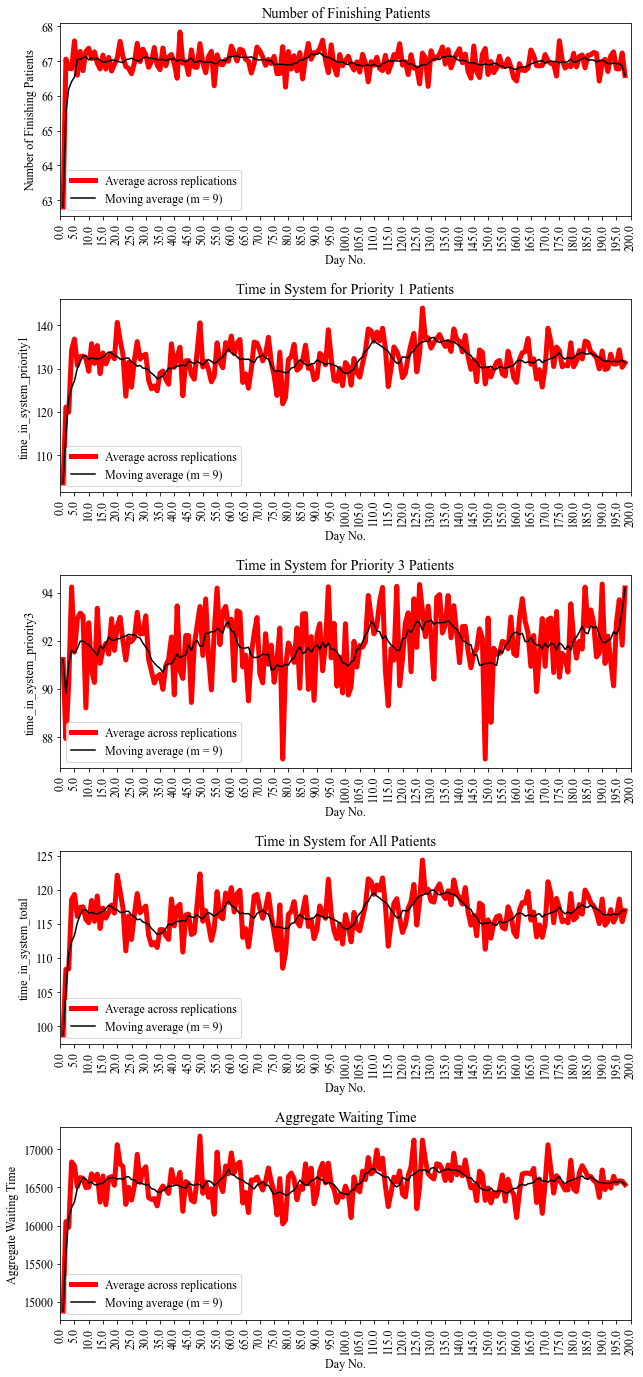

In [ ]:
"""
Simulation of a Clinic
Input Distributions:
    1- Entering population: poisson with mean = 21 people per hour
        (Inter-arrival time: Exponential with mean = 21 minutes)
    2- Service1 time for urgent patients: triangular(22, 40, 62) minutes
    3- Service1 time for normal patients: 40 * beta(1, 3) + 3 minutes
    4- Service2 time for urgent patients: triangular(10, 12, 14) minutes
    5- Service2 time for normal patients: uniform(8, 12) minutes
No limits on queue length
People get served based on a FIFO discipline
Outputs:
    1- Average queue length for each prioririty
    2- Maximum queue length for each prioririty
    3- Average waiting time in queue for each priority
    4- doctors utilization
    5- Percentage of patients who do not have waiting times in queues
    6- Average staying time for each priority at system
    7- ...
System starts at an empty state with two free doctors

Author: Negin Ashrafi
Date: 2/5/2022
"""

import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import pandas as pd
from colorama import Fore
from statistics import mean
from scipy import stats

def starting_state():

    # State Variables
    state = dict()
    state['Queue Length Priority 1'] = 0
    state['Queue Length Priority 2'] = 0
    state['Queue Length Priority 3'] = 0
    state['Number of Free Doctors'] = 2

    # Save Data
        # To track each patient
    data = dict()
    data['Patient'] = dict()

        #To track the queue of each priority
    data['Queue'] = dict()
    data['Queue']['Queue 1'] = dict()
    data['Queue']['Queue 1']['length'] = dict()
    data['Queue']['Queue 1']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 1']['Arrival Times'] = dict()
    data['Queue']['Queue 2'] = dict()
    data['Queue']['Queue 2']['length'] = dict()
    data['Queue']['Queue 2']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 2']['Enter Times'] = dict()
    data['Queue']['Queue 3'] = dict()
    data['Queue']['Queue 3']['length'] = dict()
    data['Queue']['Queue 3']['length'][0] = 0 # Queue is empty in the beginning
    data['Queue']['Queue 3']['Arrival Times'] = dict()

    # Starting FEL
    future_event_list = list()
    future_event_list.append({'Event Type': 'Arrival', 'Event Time': 0 , 'Patient Name': 'P1'})
    future_event_list.append({'Event Type': 'End of Simulation', 'Event Time': simulation_days*1440, 'Patient Name': None })

    return state, future_event_list, data

global simulation_days
global replication_number

simulation_days = 200
replication_number = 1000
window_size = 9
tick_spacing = 5


#Functions to generate random variables
def Exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)

def Triangular(a, b, c):
    r = random.random()
    if r <= (b-a) / (c-a):
        return math.sqrt(r * (b-a) * (c-a)) + a
    else:
        return c - math.sqrt((1-r) * (c-b) * (c-a))

def Uniform(a, b):
    r = random.random()
    return a + (b - a) * r

def Beta(a, b):
    return np.random.beta(a, b)


#To add an event to "Future Event List"
def fel_maker(future_event_list, event_type, clock, data, Patient):
    #Generate the random time/duration
    event_time = 1

    if event_type == 'Arrival':
        event_time = clock + Exponential(1/21)
    elif event_type == 'End of Service1':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(22, 40, 62)
        else:
            event_time = clock + 40 * Beta(1, 3) + 3
    elif event_type == 'End of Service2':
        if data['Patient'][Patient]['Priority']['First Service'] == 3:
            event_time = clock + Triangular(10, 12, 14)
        else:
            event_time = clock + Uniform(8, 12)

    #Add the event to the list
    new_event = {'Event Type': event_type, 'Event Time': event_time, 'Patient Name': Patient}
    future_event_list.append(new_event)


def Arrival(future_event_list, state, clock, data, Patient):

    #Define a new patient
    data['Patient'][Patient] = dict()
    data['Patient'][Patient]['Priority'] = dict()
    data['Patient'][Patient]['Priority']['First Service'] = 0
    data['Patient'][Patient]['Priority']['Second Service'] = 0
    data['Patient'][Patient]['Arrival Time'] = clock
    data['Patient'][Patient]['Start of Service'] = [1000000,1000000]
    data['Patient'][Patient]['End of Service'] = [1000000,1000000]

    #Assign a random priority
    r = random.random()
    if r <= 0.4:
        data['Patient'][Patient]['Priority']['First Service'] = 3
    else:
        data['Patient'][Patient]['Priority']['First Service'] = 1

    #Check the availability of doctors
    if state['Number of Free Doctors'] == 0:    #No doctors available
        #Check the patient's priority
        if data['Patient'][Patient]['Priority']['First Service'] == 3:   #Urgent patient

            #cumulative & data
                #Update queue 3 length and arrival times
            state['Queue Length Priority 3'] += 1
            data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
            data['Queue']['Queue 3']['Arrival Times'][Patient] = clock

                #Add patient to queue 3
            data['Queue']['Queue 3'][Patient] = dict()
            data['Queue']['Queue 3'][Patient]['Arrival Time'] = clock

        else: #Normal Patient

            #cumulative & data
                #Update queue 1 length and arrival times
            state['Queue Length Priority 1'] += 1
            data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
            data['Queue']['Queue 1']['Arrival Times'][Patient] = clock

                #Add patient to queue 1
            data['Queue']['Queue 1'][Patient] = dict()
            data['Queue']['Queue 1'][Patient]['Arrival Time'] = clock

    else: #There is at least 1 free doctor

        #cumulative & data
            #Update data for patient
        data['Patient'][Patient]['Start of Service'][0] = clock

        state['Number of Free Doctors'] -= 1

        #Generate end of service1 for the patient
        fel_maker(future_event_list, 'End of Service1', clock, data, Patient)

    #Generate arrival of next patient
    next_patient = 'P' + str(int(Patient[1:]) + 1)
    fel_maker(future_event_list, 'Arrival', clock, data, next_patient)

    return Patient


def End_of_Service(future_event_list, state, clock, data, Patient):

    #cumulative & data
    if data['Patient'][Patient]['Priority']['Second Service'] == 0: #Patient's 1st service has ended

        #Update patient data & priority
        data['Patient'][Patient]['End of Service'][0] = clock
        data['Patient'][Patient]['Priority']['Second Service'] = 2

        state['Queue Length Priority 2'] += 1

        #Update queue 2 length and enter times
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']
        data['Queue']['Queue 2']['Enter Times'][Patient] = clock

    else: #Patient's 2nd service has ended

        #Update patient data
        data['Patient'][Patient]['End of Service'][1] = clock

    Check_Queue(future_event_list, state, clock, data, Patient)


def Check_Queue(future_event_list, state, clock, data, Patient):

    #First we should check the priority 3. If it is empty, then we countinue checking other priorities in order
    if state['Queue Length Priority 3'] > 0:

        #Find the first patient in queue 3
        first_patient_in_queue3 = min(data['Queue']['Queue 3']['Arrival Times'],
                                      key=data['Queue']['Queue 3']['Arrival Times'].get)
        #Remove patient from queue 3
        poping_patient = str(first_patient_in_queue3)
        data['Queue']['Queue 3']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 3'] -= 1

        #Update data of queue 3 and patient
        data['Queue']['Queue 3']['length'][clock] = state['Queue Length Priority 3']
        data['Patient'][Patient]['Start of Service'][0] = clock

        #Generate end of service1 for the patient
        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    #Checking queue 2 as queue 3 was empty
    elif state['Queue Length Priority 2'] > 0:

        #Find the first patient in queue 2
        first_patient_in_queue2 = min(data['Queue']['Queue 2']['Enter Times'],
                                      key=data['Queue']['Queue 2']['Enter Times'].get)

        #Remove patient from queue 3
        poping_patient = str(first_patient_in_queue2)
        data['Queue']['Queue 2']['Enter Times'].pop(poping_patient, None)
        state['Queue Length Priority 2'] -= 1

        #Update data of queue 2 and patient
        data['Queue']['Queue 2']['length'][clock] = state['Queue Length Priority 2']
        data['Patient'][Patient]['Start of Service'][1] = clock

        #Generate end of service2 for the patient
        fel_maker(future_event_list, 'End of Service2', clock, data, poping_patient)

    #Checking queue 1 as queue 3 & 2 were empty
    elif state['Queue Length Priority 1'] > 0:

        first_patient_in_queue1 = min(data['Queue']['Queue 1']['Arrival Times'],
                                      key=data['Queue']['Queue 1']['Arrival Times'].get)

        poping_patient = str(first_patient_in_queue1)
        data['Queue']['Queue 1']['Arrival Times'].pop(poping_patient, None)
        state['Queue Length Priority 1'] -= 1

        data['Queue']['Queue 1']['length'][clock] = state['Queue Length Priority 1']
        data['Patient'][Patient]['Start of Service'][0] = clock

        fel_maker(future_event_list, 'End of Service1', clock, data, poping_patient)

    #No patient in queue
    else:
        state['Number of Free Doctors'] += 1


def Simulation(simulation_time):

    #Define state of system in t=0
    state, future_event_list, data = starting_state()

    clock = 0

    while clock < simulation_time:

        #Find the earliest event in  FEL
        sorted_fel = sorted(future_event_list, key=lambda x: x['Event Time'])

        current_event = sorted_fel[0]
        clock = current_event['Event Time']
        Patient = current_event['Patient Name']

        if clock < simulation_time:

            if current_event['Event Type'] == 'Arrival':
                Patient = Arrival(future_event_list, state, clock, data, Patient)

            elif current_event['Event Type'] == 'End of Service1' or current_event['Event Type'] == 'End of Service2':
                End_of_Service(future_event_list, state, clock, data, Patient)

            #Remove the current event from FEL
            future_event_list.remove(current_event)

        else:
            future_event_list.clear()

    return data


mpl.rc('font', family='Times New Roman')
mpl.rc('font', size=12)


# Create an empty figure with five subplots
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
fig.tight_layout(pad = 5)

#Dicts to save a specific parameter in each day of each replication
#Keys are replications
finishing_patients_day_count = dict()
finishing_priority1_patients_day_count = dict()
finishing_priority3_patients_day_count = dict()

waiting_time_day_average = dict()  # keys are replications

time_in_system_average_priority1 = dict()
time_in_system_average_priority3 = dict()


#Function to calculate moving average of a list over a sliding window of length m.
def moving_average(input_list, m):
    output_list = []
    n = len(input_list)
    for i in range(n):
        output_list.append(sum(input_list[max(i - m // 2, 2 * i - n + 1, 0):min(i + m // 2 + 1, 2 * i + 1, n)]) / (
                min(i + m // 2, 2 * i, n - 1) - max(i - m // 2, 2 * i - n + 1, 0) + 1))
    return output_list


#Function to calculate number of patients who finish their service in a specific day of a specific replication
def calculate_number_of_finishing_patients(start_time, end_time, patients_data):

    finishing_list = list()
    number_of_finishing_patients = 0
    number_of_finishing_priority1_patients = 0
    number_of_finishing_priority3_patients = 0

    for Patient in patients_data:

        if start_time < patients_data[Patient]['End of Service'][1] <= end_time: #Patient has finished his/her 2nd service today

            number_of_finishing_patients += 1

            #Seprated based on priority
            if patients_data[Patient]['Priority']['First Service'] == 1:
                number_of_finishing_priority1_patients += 1
            else:
                number_of_finishing_priority3_patients += 1

        elif patients_data[Patient]['End of Service'][1] > end_time: #Patient's 2nd service will finish later
            break

    finishing_list = [number_of_finishing_patients, number_of_finishing_priority1_patients, number_of_finishing_priority3_patients]
    return finishing_list


#Function to calculate the time each patient spends in sytem in a specific day of a specific replication
def calculate_time_in_system(start_time, end_time, patients_data):

    cumulative_time_in_system = [0,0]

    for Patient in patients_data:

        # a flag variable!
        if patients_data[Patient]['Priority']['First Service'] == 3:
            urgent = 1
        else:
            urgent = 0

        if start_time <= patients_data[Patient]['Arrival Time'] < end_time: #Patient has arrived today

            if patients_data[Patient]['End of Service'][1] <= end_time: #both services have finished and patient has left
                cumulative_time_in_system[urgent] += patients_data[Patient]['End of Service'][1] - \
                                                     patients_data[Patient]['Arrival Time']

            else: #patient is still in system
                cumulative_time_in_system[urgent] += end_time - patients_data[Patient]['Arrival Time']

        elif patients_data[Patient]['Arrival Time'] < start_time: #Patient has arrived before today

            if start_time <= patients_data[Patient]['End of Service'][1] <= end_time: #patient has left today
                cumulative_time_in_system[urgent] += patients_data[Patient]['End of Service'][1] - start_time

            elif end_time < patients_data[Patient]['End of Service'][1]: #patient is still in system (very very rare!)
                cumulative_time_in_system[urgent] += end_time - start_time

        else: #Patient will arrive later
            break

    return cumulative_time_in_system

#Function to calculate the time each patient waits in queues in a specific day of a specific replication
def calculate_waiting_time(start_time, end_time, patients_data):

    cumulative_waiting_time = 0

    for Patient in patients_data:

        if start_time <= patients_data[Patient]['Arrival Time'] < end_time: #Patient has arrived today

            if patients_data[Patient]['Start of Service'][0] < end_time: #Patient's service has started today

                if patients_data[Patient]['Start of Service'][1] < end_time:  #Patient's both services have ended today

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time'] + \
                                                patients_data[Patient]['Start of Service'][1] - \
                                                patients_data[Patient]['End of Service'][0]

                elif (patients_data[Patient]['End of Service'][0] <= end_time and #Patient has ended the 1st service
                        patients_data[Patient]['Start of Service'][1] >= end_time): #but didn't start the 2nd service

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time'] + \
                                                end_time - \
                                                patients_data[Patient]['End of Service'][0]

                elif patients_data[Patient]['End of Service'][0] > end_time: #Patient's 1st service has not finished

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                patients_data[Patient]['Arrival Time']

            else:   #Patient's service is not started yet

                cumulative_waiting_time += end_time - \
                                           patients_data[Patient]['Arrival Time']

        elif (patients_data[Patient]['Arrival Time'] < start_time and #Patient has arrived sooner
                start_time <= patients_data[Patient]['Start of Service'][0]): #but his/her service has started today

            if patients_data[Patient]['Start of Service'][0] < end_time: #Patient has started the 1st service

                if patients_data[Patient]['Start of Service'][1] < end_time:  #Patient has ended both services

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                start_time + \
                                                patients_data[Patient]['Start of Service'][1] - \
                                                patients_data[Patient]['End of Service'][0]

                elif (patients_data[Patient]['End of Service'][0] < end_time and #Patient has ended the 1st service
                        patients_data[Patient]['Start of Service'][1] > end_time): #but didn't start the 2nd service

                    cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                                start_time + \
                                                end_time - \
                                                patients_data[Patient]['End of Service'][0]

                elif patients_data[Patient]['End of Service'][0] > end_time: #Patient's 1st service is not finished yet

                     cumulative_waiting_time += patients_data[Patient]['Start of Service'][0] - \
                                               start_time

            elif end_time < patients_data[Patient]['Start of Service'][0] < 1000000 :  #Patient has not started any services yet(very very rare!)

                 cumulative_waiting_time += end_time - \
                                            start_time

        elif patients_data[Patient]['Arrival Time'] > end_time: #Patient will arrive later
            break

    return cumulative_waiting_time



for replication in range(1,replication_number + 1):

    simulation_data = Simulation(simulation_days*1440)

    patients_data = simulation_data['Patient']

    #Lists to save parameters in each day of this replication
    finishing_patients_day_count[replication] = list()
    finishing_priority1_patients_day_count[replication] = list()
    finishing_priority3_patients_day_count[replication] = list()

    waiting_time_day_average[replication] = list()

    list_time_in_system = list()
    time_in_system_average_priority1[replication] = list()
    time_in_system_average_priority3[replication] = list()

    for time in range(0,(simulation_days - 2)*1440 , 1440 ):

        #Appending calculated parameteres to pre-defined lists
        list_finishing_numbers = calculate_number_of_finishing_patients(time, time + 1440, patients_data)
        finishing_patients_day_count[replication].append(list_finishing_numbers[0])
        finishing_priority1_patients_day_count[replication].append(list_finishing_numbers[1])
        finishing_priority3_patients_day_count[replication].append(list_finishing_numbers[2])

        waiting_time_day_average[replication].append(calculate_waiting_time(time, time + 1440, patients_data))

        list_time_in_system = calculate_time_in_system(time, time + 1440, patients_data)
        time_in_system_average_priority1[replication].append(list_time_in_system[0])
        time_in_system_average_priority3[replication].append(list_time_in_system[1])

#Lists to save parameters' average of each day in all replications
finishing_patients_replication_average = list()
finishing_priority1_patients_replication_average = list()
finishing_priority3_patients_replication_average = list()

waiting_time_replication_average = list()

time_in_system_priority1_replication_average = list()
time_in_system_priority3_replication_average = list()
time_in_system_total_replication_average = list()

Days = [ i for i in range(1,simulation_days - 1)] #Eliminiating 2 last days


for i in range(0, simulation_days - 2):

    average_finishing_patients = 0
    average_finishing_priority1_patients = 0
    average_finishing_priority3_patients = 0

    average_waiting_time = 0

    averge_priority1_time_in_system = 0
    averge_priority3_time_in_system = 0


    for replication in range(1, replication_number + 1):

        #Cumulatively calculating average of parameters in each replication
        average_finishing_patients += finishing_patients_day_count[replication][i] / replication_number
        average_finishing_priority1_patients += finishing_priority1_patients_day_count[replication][i] / replication_number
        average_finishing_priority3_patients += finishing_priority3_patients_day_count[replication][i] / replication_number

        average_waiting_time += waiting_time_day_average[replication][i] * (1 / replication_number)

        averge_priority1_time_in_system += time_in_system_average_priority1[replication][i] / replication_number
        averge_priority3_time_in_system += time_in_system_average_priority3[replication][i] / replication_number

    #Appending the average of replication to lists
    finishing_patients_replication_average.append(average_finishing_patients)
    finishing_priority1_patients_replication_average.append(average_finishing_priority1_patients)
    finishing_priority3_patients_replication_average.append(average_finishing_priority3_patients)

    waiting_time_replication_average.append(average_waiting_time)

    time_in_system_priority1_replication_average.append(averge_priority1_time_in_system / finishing_priority1_patients_replication_average[i])
    time_in_system_priority3_replication_average.append(averge_priority3_time_in_system / finishing_priority3_patients_replication_average[i])
    time_in_system_total_replication_average.append((averge_priority1_time_in_system + averge_priority3_time_in_system)/finishing_patients_replication_average[i])


moving_finishing_patients_replication_average = moving_average(finishing_patients_replication_average, window_size)
moving_waiting_time_replication_average = moving_average(waiting_time_replication_average, window_size)
moving_time_in_system_priority1_replication_average = moving_average(time_in_system_priority1_replication_average, window_size)
moving_time_in_system_priority3_replication_average = moving_average(time_in_system_priority3_replication_average, window_size)
moving_time_in_system_total_replication_average = moving_average(time_in_system_total_replication_average, window_size)


ax[0].plot(Days, finishing_patients_replication_average, 'r', linewidth=5, label="Average across replications")
ax[0].plot(Days, moving_finishing_patients_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[0].set_xlim([0,200])
ax[0].set_title('Number of Finishing Patients')
ax[0].set_xlabel('Day No.')
ax[0].set_ylabel('Number of Finishing Patients')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 90)
ax[0].legend()

ax[1].plot(Days, time_in_system_priority1_replication_average, 'r', linewidth=5, label="Average across replications")
ax[1].plot(Days, moving_time_in_system_priority1_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[1].set_xlim([0,200])
ax[1].set_title('Time in System for Priority 1 Patients')
ax[1].set_xlabel('Day No.')
ax[1].set_ylabel('time_in_system_priority1')
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 90)
ax[1].legend()

ax[2].plot(Days, time_in_system_priority3_replication_average, 'r', linewidth=5, label="Average across replications")
ax[2].plot(Days, moving_time_in_system_priority3_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[2].set_xlim([0,200])
ax[2].set_title('Time in System for Priority 3 Patients')
ax[2].set_xlabel('Day No.')
ax[2].set_ylabel('time_in_system_priority3')
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[2].set_xticklabels(ax[2].get_xticks(), rotation = 90)
ax[2].legend()

ax[3].plot(Days, time_in_system_total_replication_average, 'r', linewidth=5, label="Average across replications")
ax[3].plot(Days, moving_time_in_system_total_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[3].set_xlim([0,200])
ax[3].set_title('Time in System for All Patients')
ax[3].set_xlabel('Day No.')
ax[3].set_ylabel('time_in_system_total')
ax[3].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[3].set_xticklabels(ax[3].get_xticks(), rotation = 90)
ax[3].legend()

ax[4].plot(Days, waiting_time_replication_average, 'r', linewidth=5, label="Average across replications")
ax[4].plot(Days, moving_waiting_time_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[4].set_xlim([0,200])
ax[4].set_title('Aggregate Waiting Time')
ax[4].set_xlabel('Day No.')
ax[4].set_ylabel('Aggregate Waiting Time')
ax[4].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[4].set_xticklabels(ax[4].get_xticks(), rotation = 90)
ax[4].legend()

fig.show()
fig.savefig('Warm-up analysis - Time-Day Approach')

""" End """""

In [ ]:
round(np.mean(time_in_system_total_replication_average[15:]), 3)

116.532